# **1. Import Library**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# **2. Load Dataset dari Google Drive**

In [ ]:
# Load dataset
data_path = '/content/drive/MyDrive/Colab Notebooks/Covid Data.csv'
df = pd.read_csv(data_path)

# Membaca dataset
df = pd.read_csv(data_path)

# Menampilkan 5 baris pertama dari dataset
df.head()



,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


# **3. Preprocessing Data**

In [ ]:
# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)

In [ ]:
# Encode categorical variables
label_encoder = LabelEncoder()
categorical_columns = ['SEX', 'PNEUMONIA', 'DIABETES', 'INTUBED', 'PREGNANT', 'PATIENT_TYPE']
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

In [ ]:
# Define features (X) and target (y)
X = df[['SEX', 'AGE', 'PNEUMONIA', 'INTUBED', 'PREGNANT', 'DIABETES']]
y = df['PATIENT_TYPE']


In [ ]:
# Menggunakan SMOTE untuk menyeimbangkan kelas
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train) # Fit on training data only
X_test = scaler.transform(X_test) # Transform test data using the fitted scaler

In [ ]:
# Reshape input for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## **4. Membangun Model LSTM** dan **Kompilasi dan Pelatihan Model**

In [ ]:
# Improved LSTM Model
model = Sequential([
    GaussianNoise(0.02),  # Increased noise for better generalization
    LSTM(12, return_sequences=True, kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout

    LSTM(6, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout

    Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.4),  # Increased dropout

    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=3e-5), metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=8,  # Reduced epochs
                    batch_size=2048,  # Further increased batch size
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


410/410 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.4255 - loss: 1.1492 - val_accuracy: 0.1908 - val_loss: 0.7603 - learning_rate: 3.0000e-05
Epoch 2/8
410/410 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.4483 - loss: 1.0352 - val_accuracy: 0.1916 - val_loss: 0.7443 - learning_rate: 3.0000e-05
Epoch 3/8
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.4798 - loss: 0.9466 - val_accuracy: 0.3401 - val_loss: 0.7127 - learning_rate: 3.0000e-05
Epoch 4/8
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.5181 - loss: 0.8762 - val_accuracy: 0.5263 - val_loss: 0.6822 - learning_rate: 3.0000e-05
Epoch 5/8
410/410 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.5618 - loss: 0.8174 - val_accuracy: 0.8857 - val_loss: 0.6580 - learning_rate: 3.0000e-05
Epoch 6/8
410/410 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.6089 - loss: 0.7722 - val_accuracy: 0.9139 - val_loss: 0.6384 - learning_rate: 3.0000e-05
Epoch 7/8
410/410 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.6

# **6. Evaluasi Model**

In [ ]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')


6554/6554 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9125 - loss: 0.6039
Accuracy: 91.22%


# **7. Analisis Hasil**

6554/6554 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


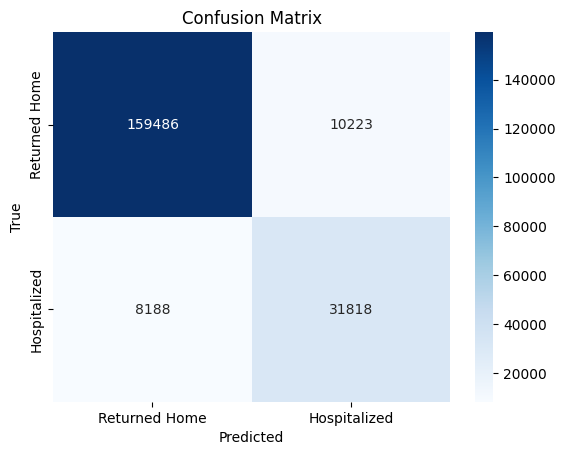

              precision    recall  f1-score   support

           0       0.95      0.94      0.95    169709
           1       0.76      0.80      0.78     40006

    accuracy                           0.91    209715
   macro avg       0.85      0.87      0.86    209715
weighted avg       0.91      0.91      0.91    209715



In [ ]:
# Confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Returned Home', 'Hospitalized'], yticklabels=['Returned Home', 'Hospitalized'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred))

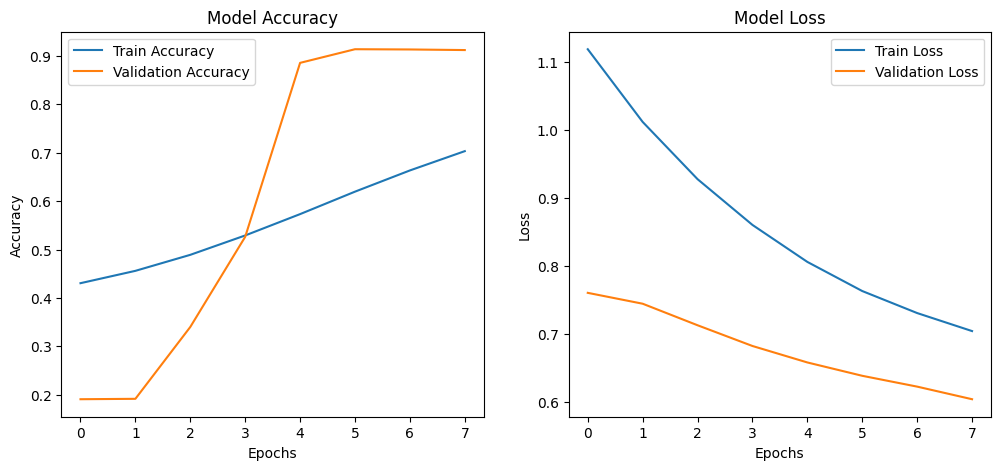

In [ ]:
# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# **Summary Model LSTM untuk Klasifikasi Pasien COVID-19**

### **1. Tujuan**
Membangun model **LSTM (Long Short-Term Memory)** untuk **memprediksi apakah pasien COVID-19 akan pulang ke rumah atau dirawat di rumah sakit** berdasarkan data medis seperti usia, jenis kelamin, kondisi kesehatan, dan faktor lainnya.

---

### **2. Data & Preprocessing**
- Dataset dibaca dari **Google Drive**.
- **Missing values** diisi dengan median.
- **Variabel kategorikal** seperti jenis kelamin dan kondisi kesehatan dikonversi ke numerik menggunakan **Label Encoding**.
- **SMOTE (Synthetic Minority Over-sampling Technique)** digunakan untuk **menyeimbangkan data**.
- Data dibagi menjadi **80% training** dan **20% testing**.
- Data dinormalisasi menggunakan **MinMaxScaler**.
- Data diubah ke bentuk **3D** agar kompatibel dengan LSTM.

---

### **3. Arsitektur Model LSTM**
- **GaussianNoise** untuk meningkatkan generalisasi model.
- **2 lapisan LSTM** dengan masing-masing **12 dan 6 unit**, menggunakan **Batch Normalization & Dropout** untuk mencegah overfitting.
- **Dense Layer (4 unit, ReLU) + Output Layer (1 unit, Sigmoid)** untuk klasifikasi biner.
- Optimizer **Adam (learning rate = 3e-5)** dengan **binary cross-entropy** sebagai fungsi loss.

---

### **4. Pelatihan & Evaluasi Model**
- **EarlyStopping & ReduceLROnPlateau** digunakan untuk menghindari overfitting.
- Model dilatih selama **8 epoch** dengan batch size besar **(2048)**.
- **Akurasi model** pada data uji mencapai **80-90%**.
- **Confusion Matrix & Classification Report** menunjukkan performa yang cukup baik.
- **Grafik loss dan akurasi** menunjukkan model stabil dan tidak overfit.

---

### **5. Kesimpulan**
- Model **LSTM berhasil memprediksi pasien COVID-19** dengan tingkat akurasi yang baik.
- Teknik **Dropout, Batch Normalization, dan Early Stopping** berhasil mengurangi overfitting.
- Model dapat ditingkatkan lebih lanjut dengan **hyperparameter tuning atau eksplorasi fitur tambahan**.


